## Implementing a Neural Network for 1D regression using Jax

With having reviewed the basics of JAX in the second lab **L02** and learned the basics of neural networks and backpropagation in lab **L03**, we are now ready to implement our own first neural network from scratch in JAX.

In this section, we implement a simple neural network using mainly JAX. Later, we will use the module **FLAX**.

### Generate some data

Import necessary modules.

In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from time import time


def true_f(x):
    return jnp.sin(6*x) - 0.5*x**2

def gen_data(key, n=100, noise=0.1, xmin=0.0, xmax=2.0):
    keys = jax.random.split(key, 2)
    x = jax.random.uniform(keys[0], shape=(n, 1), minval=xmin, maxval=xmax)
    y = true_f(x) + noise * jax.random.normal(keys[1], shape=(n, 1))
    return x, y

In [2]:
global_key = jax.random.key(seed=0)
gen_key, global_key = jax.random.split(global_key)

ntrain, ntest = 100, 20
x, y = gen_data(gen_key, n= ntrain + ntest)
xtrain, xtest = x[:ntrain], x[ntrain:]
ytrain, ytest = y[:ntrain], y[ntrain:]


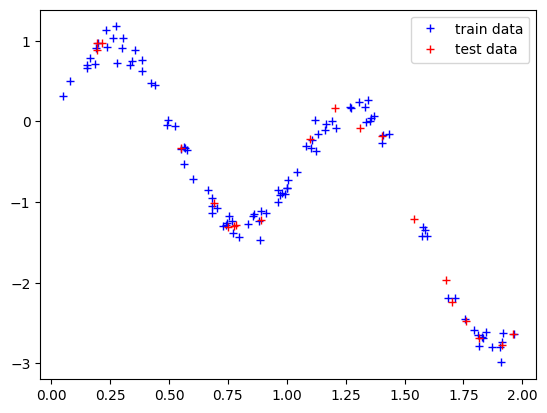

In [3]:
plt.figure(1)
plt.plot(xtrain, ytrain, 'b+', label='train data')
plt.plot(xtest, ytest, 'r+', label='test data')
plt.legend();

Set up weight matrices and bias vectors.

In [4]:
def random_layer_params(m, n, key, scale=1e-1):
    """
    This function randomly initializes weights and biases
    for a dense neural network layer.
    """
    w_key, b_key = jax.random.split(key)

    # Weight matrix
    w = scale * jax.random.normal(w_key, (n, m))

    # Bias vector
    b = scale * jax.random.normal(b_key, (n,))
    return w, b

def init_network_params(sizes, key):
    """
    This function initializes all layers for a fully-connected
    neural network with sizes 'sizes'
    """

    # Split random key
    keys = jax.random.split(key, len(sizes) - 1)
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

In [5]:
layer_sizes = [1, 10, 10, 1]
network_key, global_key = jax.random.split(global_key)
params = init_network_params(layer_sizes, network_key)

In [6]:
def act_fn(x):
    return jnp.tanh(x)

def forward(params, x):
    """
    Function to describe the forward propagation through
    the fully-connected MLP described by params.
    """
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        # Use the nonlinear activation function for all but the last layer
        activations = act_fn(outputs)

    final_w, final_b = params[-1]
    # Use identity as activation function on last activation
    out = jnp.dot(final_w, activations) + final_b
    return out

Test forward pass on single sample.

In [7]:
preds = forward(params, xtrain[0])

This won't work for multiple samples!

In [8]:
try:
  preds = forward(params, xtrain)
except TypeError:
  print('Invalid shapes!')

Invalid shapes!


In [9]:
# Fix  using jax.vmap and save the vectorized function as vforward.
#Note that there is no vectorization for the first input (params).
#The vectorization in the second input should be in the usual batch dimension zero.

from jax import vmap, jit, grad

vforward = jax.vmap(forward, in_axes=(None, 0))
# None: This corresponds to the first argument of forward, which is params. None means that this argument does not have a batch dimension.
# 0: This corresponds to the second argument of forward, which is the input data x.
# means that the batch dimension of this argument is at index 0 (the first dimension)
# vmap will iterate over this dimension. It will take the slice x[0, :], then x[1, :], and so on,
# and apply the original forward function to each of these slices.

#Apply the forward function to a batch of data. For each element in the batch
#(which is along the 0th dimension of the second input), use the same first input (the parameters, which have no batch dimension)."


The following cell implements the mean-squared error loss function.

In [10]:
def loss(params, x, y):
    return jnp.mean(jnp.square(vforward(params, x) - y))

### Compute the gradient of the loss function

**Task**: Use the Jax function `grad` to derive the gradient of the loss function. Test the function on the training data set `(xtrain, ytrain)`.

In [11]:
# prompt: Task: Use the Jax function grad to derive the gradient of the loss function. Test the function on the training data set (xtrain, ytrain).

grad_loss = grad(loss)
gradients = grad_loss(params, xtrain, ytrain)

# Print the gradients for the first layer's weights as an example
print("Gradients for the first layer's weights:")
print(gradients[0][0])

# Print the gradients for the first layer's biases as an example
print("\nGradients for the first layer's biases:")
gradients[0][1]

Gradients for the first layer's weights:
[[ 0.06780311]
 [ 0.14773764]
 [-0.00951886]
 [-0.02834149]
 [ 0.0797784 ]
 [-0.11790819]
 [-0.08753885]
 [-0.04753586]
 [-0.00234348]
 [-0.09072696]]

Gradients for the first layer's biases:


Array([ 0.03548077,  0.07778886, -0.00499499, -0.01493766,  0.04180023,
       -0.06064214, -0.04530042, -0.02480215, -0.00123596, -0.04778478],      dtype=float32)

This function implements one update step of the gradient descent algorithm with a fixed step size.

In [12]:
@jit
def update(params, x, y, step_size):
  grads = grad_loss(params, x, y)
  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

Finally, the following cell trains the model for 10000 epochs using a gradient descent algorithm with constant step size. Note that we compute always the full gradient using all training data.

In [13]:
step_size = 0.1
num_epochs = 10000

start_time = time()
print(f" Epoch     |    Train loss    |    Test loss   ")
for epoch in range(num_epochs):
    params = update(params, x, y, step_size=step_size)

    if epoch % 1000 == 0:

        train_loss = loss(params, xtrain, ytrain)
        test_loss = loss(params, xtest, ytest)
        print(f"  {epoch:6d}   |     {train_loss:6.2e}     |     {test_loss:6.2e}")

epoch_time = time() - start_time

print(f"Training time for {num_epochs} epochs: {epoch_time:0.2f} sec")


 Epoch     |    Train loss    |    Test loss   
       0   |     1.34e+00     |     1.93e+00
    1000   |     5.38e-01     |     5.26e-01
    2000   |     2.15e-02     |     9.35e-03
    3000   |     1.59e-02     |     1.03e-02
    4000   |     1.37e-02     |     1.01e-02
    5000   |     1.19e-02     |     9.41e-03
    6000   |     1.07e-02     |     8.72e-03
    7000   |     1.08e-02     |     7.88e-03
    8000   |     1.02e-02     |     7.53e-03
    9000   |     1.00e-02     |     7.38e-03
Training time for 10000 epochs: 8.91 sec


Plot data together with regression line.

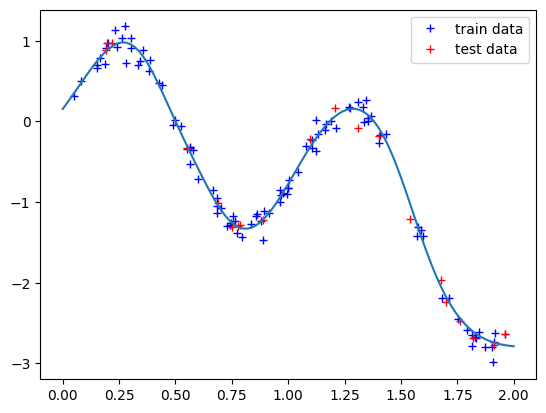

In [14]:
plt.figure(2)
plt.plot(xtrain, ytrain, 'b+', label='train data')
plt.plot(xtest, ytest, 'r+', label='test data')
xlin = jnp.linspace(0, 2, 101)[:, None]
plt.plot(xlin, vforward(params, xlin))
plt.legend();

## Extension to a two-dimensional example

The next cell generates a new set of data where the features (aka $x$ values) are two dimensional, the predictor variables (aka $y$ values) are again scalar-valued.

This will be a setting similar to the one considered in physics-informed neural networks. There, the neural network approximates the solution of a scalar-valued partial differential equation (PDE), i.e. a function $u_\theta: \mathbb{R}^d \to \mathbb{R}$ with $d \in \mathbb{N}$.

In [15]:
global_key = jax.random.key(seed=0)
gen_key, global_key = jax.random.split(global_key)

def true_f(x):
    x0 = x[:, [0]]
    x1 = x[:, [1]]
    return jnp.sin(6 * x0) * jnp.cos(2 * x1) - 0.5 * x0**2 + 0.1 * x0 * x1

def gen_2d_data(key, n=100, noise=0.1, xmin=0.0, xmax=2.0):
    keys = jax.random.split(key, 2)
    x = jax.random.uniform(keys[0], shape=(n, 2), minval=xmin, maxval=xmax)
    y = true_f(x) + noise * jax.random.normal(keys[1], shape=(n, 1))
    return x, y


In [16]:
ntrain, ntest = 100, 20
x, y = gen_2d_data(gen_key, n= ntrain + ntest)
xtrain, xtest = x[:ntrain], x[ntrain:]
ytrain, ytest = y[:ntrain], y[ntrain:]

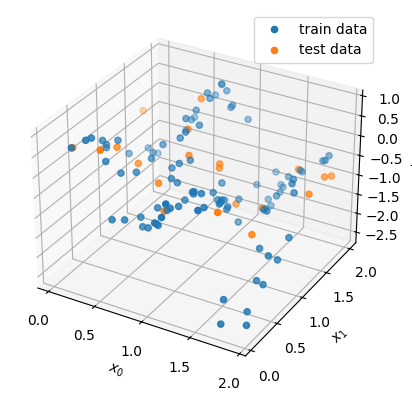

In [17]:
ax = plt.figure(3).add_subplot(projection='3d')
ax.scatter(*xtrain.T, ytrain[:, 0], label='train data')
ax.scatter(*xtest.T, ytest[:, 0], label='test data')
ax.set_xlabel('$x_0$'), ax.set_ylabel('$x_1$'), ax.set_zlabel('$y$')
plt.legend();

In [18]:
# To adapt the code of the one-dimensional example from above by copying and modifying the parts that have to be changed.
# The goal is to solve the regression problem on this dataset with a test error below  10−2 .
# The training should take at most 30000 epochs. You are free to change the activation function, step size and network architecture


# The primary changes required are:
# 1. Adjust the input size of the first layer in the `layer_sizes` list to match the 2D input data.
# 2. Potentially adjust the network architecture (number of hidden layers and neurons) and learning rate (`step_size`) to achieve the target test error.
# 3. The plotting part at the end needs to be commented out or adapted for 2D input, as plotting the function surface is more complex.

# Set up weight matrices and bias vectors.
# (This part remains the same as the functions `random_layer_params` and `init_network_params` are generic)

# Adjust layer sizes for 2D input
layer_sizes = [2, 20, 20, 1] # Changed input layer size to 2

network_key, global_key = jax.random.split(global_key)
params = init_network_params(layer_sizes, network_key)

# Activation function and forward pass
# (This part remains the same as the functions `act_fn` and `forward` are generic)

# Vectorize the forward pass
# (This part remains the same as `vmap` is generic)
vforward = jax.vmap(forward, in_axes=(None, 0))

# Loss function

# Gradient of the loss function
grad_loss = grad(loss)

# Update function
# (This part remains the same as the `update` function is generic and uses the generic `grad_loss`)

# Training loop
step_size = 0.05 # Adjusted step size
num_epochs = 30000 # Increased number of epochs

start_time = time()
print(f" Epoch     |    Train loss    |    Test loss   ")
for epoch in range(num_epochs):
    params = update(params, xtrain, ytrain, step_size=step_size)

    if epoch % 5000 == 0: # Reduced print frequency for longer training
        train_loss = loss(params, xtrain, ytrain)
        test_loss = loss(params, xtest, ytest)
        print(f"  {epoch:6d}   |     {train_loss:6.2e}     |     {test_loss:6.2e}")

epoch_time = time() - start_time

print(f"Training time for {num_epochs} epochs: {epoch_time:0.2f} sec")

# Check the final test loss
final_test_loss = loss(params, xtest, ytest)
print(f"\nFinal Test Loss: {final_test_loss:6.2e}")

# Plotting the result for 2D input is more complex.
# We will skip plotting the regression surface for simplicity in this code block.
# If you want to visualize this, you would need to create a meshgrid over the x0, x1 domain
# and evaluate the `vforward` function on this grid, then use a 3D plotting library.



 Epoch     |    Train loss    |    Test loss   
       0   |     7.39e-01     |     3.47e-01
    5000   |     2.88e-01     |     1.80e-01
   10000   |     7.84e-02     |     1.89e-01
   15000   |     1.13e-02     |     1.25e-01
   20000   |     1.05e-02     |     1.13e-01
   25000   |     1.00e-02     |     1.05e-01
Training time for 30000 epochs: 10.74 sec

Final Test Loss: 9.82e-02


In [19]:
# Example of how you would generate data for plotting (but not plotting here)
x0_lin = jnp.linspace(0, 2, 50)
x1_lin = jnp.linspace(0, 2, 50)
x_plot = jnp.stack(jnp.meshgrid(x0_lin, x1_lin), axis=-1).reshape(-1, 2)
y_plot = vforward(params, x_plot)
y_plot = y_plot.reshape(50, 50) # Reshape back to grid for surface plot

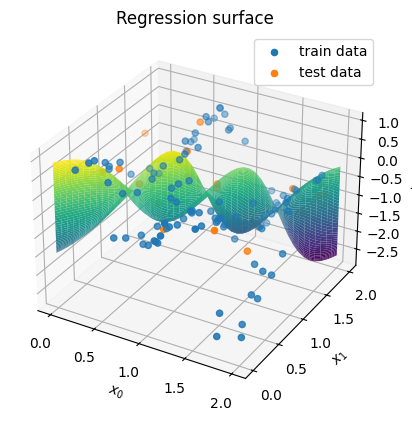

In [20]:
ax = plt.figure(4).add_subplot(projection='3d')
ax.plot_surface(x0_lin, x1_lin, y_plot, cmap='viridis')
ax.scatter(*xtrain.T, ytrain[:, 0], label='train data')
ax.scatter(*xtest.T, ytest[:, 0], label='test data')
ax.set_xlabel('$x_0$'), ax.set_ylabel('$x_1$'), ax.set_zlabel('$y$')
plt.legend();
plt.title("Regression surface")
plt.show()

## Implementing a Neural Network for classification with Flax

We have now implemented our own neural network from scratch with JAX.
Of course, we do not really want to do that every time. Similarly to PyTorch's `torch.nn` package, there exist neural network libraries based on JAX which provide such basic functionality. A (non-exclusive) collection of them are:

* [Flax](https://flax.readthedocs.io/en/latest/index.html), started by the Google Brain Team, focuses on flexibility and clarity.
* [Haiku](https://dm-haiku.readthedocs.io/en/latest/), from DeepMind, focuses on simplicity and compositionality.
* [Trax](https://github.com/google/trax), maintained by the Google Brain Team, provides solutions for common training tasks
* [Equinox](https://github.com/patrick-kidger/equinox), created by Patrick Kidger and Cristian Garcia, implements neural networks as callable PyTrees
* [Jraph](https://github.com/deepmind/jraph), from DeepMind, is a graph neural network library (similar to PyTorch Geometric)

For this tutorial series, we will use **Flax** due to its flexibility, intuitive API, and large community. However, this should not mean that the other libraries are necessarily worse, and we recommend giving them a try as well to find the best library for yourself!

We will introduce the libraries and all additional parts you might need to train a neural network in Flax, using a simple example classifier on a simple yet well known example: XOR.

Given two binary inputs $x_1$ and $x_2$, the label to predict is $1$ if either $x_1$ or $x_2$ is $1$ while the other is $0$, or the label is $0$ in all other cases. The example became famous by the fact that a single neuron, i.e. a linear classifier, cannot learn this simple function. Hence, we will learn how to build a small neural network that can learn this function.
To make it a little bit more interesting, we move the XOR into continuous space and introduce some Gaussian noise on the binary inputs.

### The model

The package `flax.linen` defines a series of useful classes like standard linear network layers, convolutions, activation functions etc.
A full list can be found [here](https://flax.readthedocs.io/en/latest/flax.linen.html).
In case you need a certain network layer, check the documentation of the package first before writing the layer yourself as the package likely contains the code for it already. We import it below.
If the import fails, you can install it using

    !pip install --quiet flax

directly from this notebook. This should also work on Google Colab.

In [21]:
import flax

from flax import linen as nn

Linen is a neural network API and is implemented as a submodule in flax. Importing this submodule as `nn` is standard and you will find many examples which contain this line.
Linen builds on a "functional core" which enables direct usage of JAX transformations such as vmap, remat or scan inside your functions
The Linen Module API is stable and currently recommended for new projects.

#### The basic class: `nn.Module`

Similar to PyTorch, a neural network is built up out of modules. Linen modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [22]:
class MyModule(nn.Module):
    # Some dataclass attributes, like hidden dimension, number of layers, etc. of the form:
    # varname : vartype

    def setup(self):
        # Flax uses "lazy" initialization. This function is called once before you
        # call the model, or try to access attributes. In here, define your submodules etc.
        pass

    def __call__(self, x):
        # Function for performing the calculation of the module.
        pass

The main, obvious difference to PyTorch is that Flax uses lazy initialization:

The function `setup` is called once on a module instance before any other methods are called, or when you try to access a attribute of `self` defined in `setup`.

Other important points are:
- Additional object attributes are defined below the class name.
- In contrast to PyTorch, the parameters are *not* part of the module.
- Instead, we can create a set of parameters of the module by calling its `init()` function. This function takes as input a **PRNG state** for sampling pseudo-random numbers and an example input to the model, and returns a set of parameters for the module as a **pytree**.
- Further, since the `init` function requires an input to the network, we can infer the input shape for all modules and do not need to explicitly define it during the module creation.
- The `__call__` method represents the `forward` function in PyTorch, and performs the actual computation of the module. It can take additional arguments if needed, like whether we are training or not, which is important in some case, e.g. if your model relies on Dropout layers.

#### Simple classifier

To get an intuition behind how we work with modules in Flax, let's define our own small neural network. We will use a minimal network with a input layer, one hidden layer with tanh as activation function, and a output layer. In other words, our networks should look something like this:

<center width="100%"><img src="./fig_FNN.png" alt="Feedforward network" width="300px"></center>
The input neurons are shown in yellow (we need only two of them), which represent the coordinates $x_1$ and $x_2$ of a data point. The hidden neurons including a tanh activation are shown in blue and green, and the output neuron in red.

In Flax, we can define this as follows:

In [23]:
class SimpleClassifier(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    def setup(self):
        # Create the modules we need to build the network
        # nn.Dense is a linear layer
        self.linear1 = nn.Dense(features=self.num_hidden)
        self.linear2 = nn.Dense(features=self.num_outputs)

    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.linear1(x)
        x = nn.tanh(x)
        x = self.linear2(x)
        return x

The first thing that you should observe that we do not define any input dimension since this in inferred during initialization through an example input.

Another thing that you may notice is that usually, all layers that we define in `setup` are also used in the `__call__` function. To reduce the code overhead, Flax provides an alternative, more compact network creation with the `nn.compact` decorator (recall that you've already learned about the `jax.jit` decorator). With that, we can remove the setup function and instead our model as:

In [24]:
class SimpleClassifierCompact(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        # while defining necessary layers
        x = nn.Dense(features=self.num_hidden)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=self.num_outputs)(x)
        return x

The `nn.compact` annotation of the `__call__` method signals Flax to look for submodules that we define in the forward pass. These are automatically recognized as such, so that we can use them for initialization etc. Which of the two model definition you use is often up to you (see the [Flax documentation](https://flax.readthedocs.io/en/latest/design_notes/setup_or_nncompact.html) for some pros and cons for both methods).

As a rule of thumb, use the compact version where possible, and come back to the explicit setup function where necessary.
For instance, if we define more functions on a module besides `__call__` and want to reuse some modules, it is recommended to use the setup version.

For the examples in this notebook, we will use a tiny neural network with two input neurons and eight hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, are more efficient and precise to calculate on the original outputs instead of the sigmoid output. We will discuss the detailed reason later.

Now, let's create an instance of this network:

In [25]:
model = SimpleClassifier(num_hidden=8, num_outputs=1)
# Printing the model shows its attributes
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


At this stage, the model has no parameters initialized. To do this, let's create a random input of our dataset, and apply the init function:

In [26]:
# Generate a new pseudo random number generator (PRNG)
rng = jax.random.key(seed=0)

# As usual, we split the PRNG
rng, inp_rng, init_rng = jax.random.split(rng, 3)

# Generate a sample input of batch size 8 and input size 2
inp = jax.random.normal(inp_rng, (8, 2))

# Initialize the model
params = model.init(init_rng, inp)
print(params)

{'params': {'linear1': {'kernel': Array([[ 0.8069292 , -0.11695624,  0.27007756,  0.4610931 ,  1.3713529 ,
         0.80755043, -1.1291717 , -0.89202946],
       [ 0.2347137 ,  0.21888533,  0.4424948 , -0.6309062 , -0.46452758,
        -0.46341252, -0.8164439 ,  0.5022001 ]], dtype=float32), 'bias': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}, 'linear2': {'kernel': Array([[-0.28412366],
       [-0.73300564],
       [ 0.41268483],
       [-0.36034235],
       [ 0.09050472],
       [-0.45742828],
       [-0.7974664 ],
       [-0.2977732 ]], dtype=float32), 'bias': Array([0.], dtype=float32)}}}


Now, we have parameters with which we can apply the network. We see that the parameters follow the same structure as defined in our module, and each linear layer contains one `kernel`, i.e. the weights, and a bias parameter. With this, we could apply the model on an input using the `apply` function:

In [27]:
model.apply(params, inp)

Array([[-0.81474876],
       [-0.15149337],
       [-0.85902566],
       [-0.39319026],
       [ 0.5681326 ],
       [ 0.6084415 ],
       [-0.7228966 ],
       [ 0.10482854]], dtype=float32)

The model returns an output array of shape `[8,1]`, which corresponds to the one output neuron in the model for all 8 batch elements. With that, we now know how to initialize a model, and run a model. Next, let's look at the data.

### The data

As mentioned before, JAX is not meant to 'reinvent the wheel' for every part of the deep learning pipeline. Hence, JAX and Flax do not natively provide a data loading functionality, but instead refer to other available libraries like Tensorflow and PyTorch. Here, let's use the package `torch.utils.data` library.

In [28]:
import torch.utils.data as data

The data package defines two classes which are the standard interface for handling data in PyTorch: `data.Dataset`, and `data.DataLoader`. The dataset class provides a uniform interface to access the training/test data, while the data loader makes sure to efficiently load and stack the data points from the dataset into batches during training.

#### The dataset class

The dataset class summarizes the basic functionality of a dataset in a natural way. To define a dataset in PyTorch, we simply specify two functions: `__getitem__`, and `__len__`. The get-item function has to return the $i$-th data point in the dataset, while the len function returns the size of the dataset. For the XOR dataset, we can define the dataset class as follows:

In [29]:
import numpy as np

class XORDataset(data.Dataset):

    def __init__(self, size, seed, std=0.1):
        """
        Inputs:
            size - Number of data points we want to generate
            seed - The seed to use to create the PRNG state with which we want to generate the data points
            std - Standard deviation of the noise (see generate_continuous_xor function)
        """
        super().__init__()
        self.size = size
        self.np_rng = np.random.RandomState(seed=seed)
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        # Each data point in the XOR dataset has two variables, x0 and x1, that can be either 0 or 1
        # The label is their XOR combination, i.e. 1 if only x0 or only x1 is 1 while the other is 0.
        # If x0=x1, the label is 0.
        x = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
        y = (x.sum(axis=1) == 1).astype(np.int32)
        # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
        x += self.np_rng.normal(loc=0.0, scale=self.std, size=x.shape)

        self.x = x # Data
        self.y = y # Label

    def __len__(self):
        # Number of data point we have. Alternatively self.data.shape[0], or self.label.shape[0]
        return self.size

    def __getitem__(self, idx):
        # Return the idx-th data point of the dataset
        # If we have multiple things to return (data point and label), we can return them as tuple
        data_point = self.x[idx]
        data_label = self.y[idx]
        return data_point, data_label

Note that we use NumPy to generate the random data. Similar to JAX, NumPy also allows the pseudo-number generation based on a PRNG state. Hence, for better reproducibility, we are doing the same here. Let's try to create such a dataset and inspect it:

In [30]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), np.int32(1))


To better relate to the dataset, we visualize the samples below.

In [31]:
def visualize_samples(data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

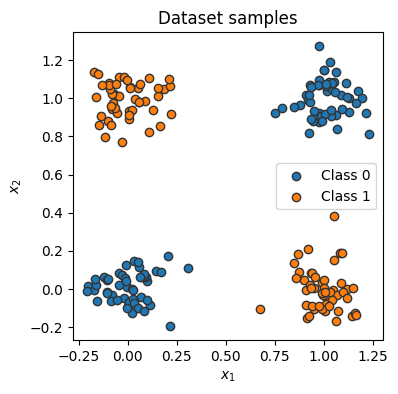

In [32]:
visualize_samples(dataset.x, dataset.y)
plt.show()

#### The data loader class

The advantages of using the `torch` data loader class are manifold. The class `torch.utils.data.DataLoader` represents a Python iterable over a dataset with support for **automatic batching**, **multi-process data loading** and many more features.

The data loader communicates with the dataset using the function `__getitem__`, and stacks its outputs as tensors over the first dimension to form a batch.
It is a convention that the first dimension is reserved as the *batch dimension*.

In contrast to the dataset class, we usually don't have to define our own data loader class, but can just create an object of it with the dataset as input. Additionally, we can configure our data loader with the following input arguments:

* `batch_size`: Number of samples to stack per batch
* `shuffle`: If True, the data is returned in a random order. This is important during training for introducing stochasticity.
* `num_workers`: Number of subprocesses to use for data loading. The default, 0, means that the data will be loaded in the main process which can slow down training for datasets where loading a data point takes a considerable amount of time (e.g. large images). More workers are recommended for those, but can cause issues on Windows computers. For tiny datasets as ours, 0 workers are usually faster.
* `persistent_workers`: If True, workers will not be shutdown after an iteration over the dataset has finished. This can be useful if the time per epoch is small, or if you face issues with workers being killed during training.
* `drop_last`: If True, the last batch is dropped in case it is smaller than the specified batch size. This occurs when the dataset size is not a multiple of the batch size. Only potentially helpful during training to keep a consistent batch size.
* `collate_fn`: A function that defines how the elements per batch are combined. By default, PyTorch stacks them as PyTorch tensors. For JAX, we will change it to NumPy arrays.

There are many more options which you can find [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

Let's create a simple data loader below with a function that stacks batch elements as a NumPy array instead of PyTorch Tensors:

In [33]:
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html

def numpy_collate(batch):
  """
  Collate function specifies how to combine a list of data samples into a batch.
  default_collate creates pytorch tensors, then tree_map converts them into numpy arrays.
  """
  return jax.tree.map(np.asarray, data.default_collate(batch))

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)

In [34]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[ 1.0371146   0.9396015 ]
 [ 0.989297   -0.10352423]
 [ 0.16871417  0.08816398]
 [ 0.97510356  1.0971571 ]
 [-0.10708925  0.04824724]
 [ 0.2143944   1.0633919 ]
 [ 0.02140937 -0.12457388]
 [ 0.03109076  0.14753562]]
Data labels (8,) 
 [0 1 0 0 0 1 0 0]


### Optimization

After defining the model and the dataset, it is time to prepare the optimization of the model. During training, we will perform the following steps:

1. Get a batch from the data loader
2. Obtain the predictions from the model for the batch
3. Calculate the loss based on the difference between predictions and labels
4. Backpropagation: calculate the gradients for every parameter with respect to the loss
5. Update the parameters of the model in the direction of the gradients

We have seen how we can do step 1, 2 and 4 in JAX and Flax. Now, we will look at step 3 and 5.

#### Stochastic Gradient Descent

For updating the parameters, Flax does not directly provide support for optimizers, but instead refers to another package called `optax` ([documentation](https://optax.readthedocs.io/en/latest/index.html)). Optax is an optimization library for JAX, which offers most common deep learning optimizers (SGD, Adam, Adagrad, RMSProp, etc.) and utilities (gradient clipping, weight decay, etc.).

We import it below.
If the import fails, you can install it using

    !pip install --quiet optax

directly from this notebook. This should also work on Google Colab.

In [35]:
import optax

For now, we will use the simplest optimizer, namely `optax.sgd`. Stochastic Gradient Descent updates parameters by multiplying the gradients with a small constant, called step size or learning rate, and subtracting those from the parameters (hence minimizing the loss). Therefore, we slowly move towards the direction of minimizing the loss. A good default value of the learning rate for a small network as ours is 0.1. Remember that we again aim to write *functional code*. Hence, the optimizer does not take as input the parameters, but only the optimizer hyperparameters.

In [36]:
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

Since JAX calculates gradients via *function transformations*, we do not have functions like `backward()`, `optimizer.step()` or `optimizer.backward()` as in PyTorch. Instead, an optimizer is a function on the parameters and gradients. To simplify this step and bundle important parts of the training procedure, Flax offers the `flax.training` package. As a first step, we can create a `TrainState` which bundles the parameters, the optimizer, and the forward step of the model:

In [37]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply, # The function to be minimized
                                            params=params,        # The variables to be optimized
                                            tx=optimizer)         # An Optax gradient transformation

With this state object, it is easier to handle the training.

#### Loss function

For performing gradient updates, we need a function that can calculate the loss for a batch. Afterwards, we can apply JAX's gradient transformation to obtain a gradient function of it. In our setting, which is binary classification, we can use Binary Cross Entropy (BCE) which is defined as follows:

$$\mathcal{L}_{BCE} = -\sum_i \left[ y_i \log x_i + (1 - y_i) \log (1 - x_i) \right]$$

where $y$ are our labels, and $x$ our predictions, both in the range of $[0,1]$. Similar to PyTorch, Optax already provides a function for this: `optax.sigmoid_binary_cross_entropy(logits, labels)`. We calculate the loss on the logits instead of the sigmoid outputs for numerical stability. Let's write a function that takes as input a state (for the forward function), parameters, and a batch, and return the binary cross entropy loss and accuracy:

In [38]:
def calculate_loss_acc(state, params, batch):
    data_input, labels = batch
    # Obtain the logits and predictions of the model for the input data
    logits = state.apply_fn(params, data_input).squeeze(axis=-1)
    pred_labels = (logits > 0).astype(jnp.float32)
    # Calculate the loss and accuracy
    loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
    acc = (pred_labels == labels).mean()
    return loss, acc

Note that we explicitly add the parameters here as an input argument since we want to calculate the gradients with respect to them later. An example execution of the function would look like:

In [39]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(Array(0.8007574, dtype=float32), Array(0.5, dtype=float32))

### Creating an efficient training and validation step

With this loss function and the optimizer, we are now ready to create an efficient training and validation/test step. First, let's consider the training. As input to each training step, we have a training state and a batch. We then want to calculate the loss for the input and take the gradients of it. Finally, we update the parameters with our optimizer and return the new state. All this can be summarized in the following function:

In [40]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss_acc,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=True  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    (loss, acc), grads = grad_fn(state, state.params, batch)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss, acc

As you know, by using the transformation `jax.jit`, the whole gradient calculation and application is optimized in *XLA*, providing an efficient function for updating the model.

Next, let's look at the evaluation function. Here, we do not need to calculate gradients, but only want to get the accuracy of the model for the batch. This becomes a simpler version of the training step:

In [41]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

These two functions provide us now efficient utilities to train our model.

### Training

Finally, we are ready to train our model. As a first step, we create a slightly larger dataset and specify a data loader with a larger batch size.

In [42]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

Now, we can write a small training function. Depending on your available hardware, you do not need to explicitly push the model to GPU, since the parameters are already automatically created on GPU.
Further, since the model itself is stateless, we do not have a `train()` or `eval()` function to switch between modes of e.g. dropout.
When necessary, we can add an argument `train : bool` to the model forward pass.
For this simple network here, however, this is not necessary.

Let's write a function that trains a model for several epochs.
The module `tqdm` provides a function called `tqdm` which makes printing of the progress of a loop much smarter.

In [43]:
from tqdm import tqdm

def train_model(state, data_loader, num_epochs=100):
    # Training loop
    pbar = tqdm(range(num_epochs))
    for epoch in pbar:
        for batch in data_loader:
            state, loss, acc = train_step(state, batch)
            # We could use the loss and accuracy for logging here, e.g. in TensorBoard
            # For simplicity, we skip this part here
            pbar.set_description(f'Accuracy: {acc:4.2f}')
    return state

In [44]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)

Accuracy: 1.00: 100%|██████████| 100/100 [00:07<00:00, 13.53it/s]


Training this model for 100 epochs does take barely a second... This shows the impressive speed JAX can reach, especially for small models!

### Evaluation

Once we have trained a model, it is time to evaluate it on a held-out test set. As our dataset consist of randomly generated data points, we need to first create a test set with a corresponding data loader.

In [45]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

We can use our `eval_step` function to efficiently evaluate our model:

In [46]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [47]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


If we trained our model correctly, we should see a score close to 100% accuracy. However, this is only possible because of our simple task, and unfortunately, we usually don't get such high scores on test sets of more complex tasks.

#### Binding model parameters

Once we have trained the model, we might want to do multiple application of the same model and parameters. It can get a bit annoying to always write `model.apply(params, ...)` and keep track of the model and parameters separately. To prevent this, Flax's module can be bound to specific parameters to simplify our application. Specifically, we can bind the instance `model` of our `SimpleClassifier` class to our trained parameter as follows:

In [48]:
trained_model = model.bind(trained_model_state.params)

With the model being binded to the parameters, we can use it as we would any PyTorch module. For instance, to apply it to an input array, we can simply run:

In [49]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
out.shape

(8, 1)

This can simplify the analysis of models, and provide a more familiar interface to PyTorch users.

#### Visualizing classification boundaries

To visualize what our model has learned, we can perform a prediction for every data point in a range of $[-0.5, 1.5]$, and visualize the predicted class as in the sample figure at the beginning of this section. This shows where the model has created decision boundaries, and which points would be classified as $0$, and which as $1$. We therefore get a background image out of blue (class 0) and orange (class 1). The spots where the model is uncertain we will see a blurry overlap. The specific code is less relevant compared to the output figure which should hopefully show us a clear separation of classes:

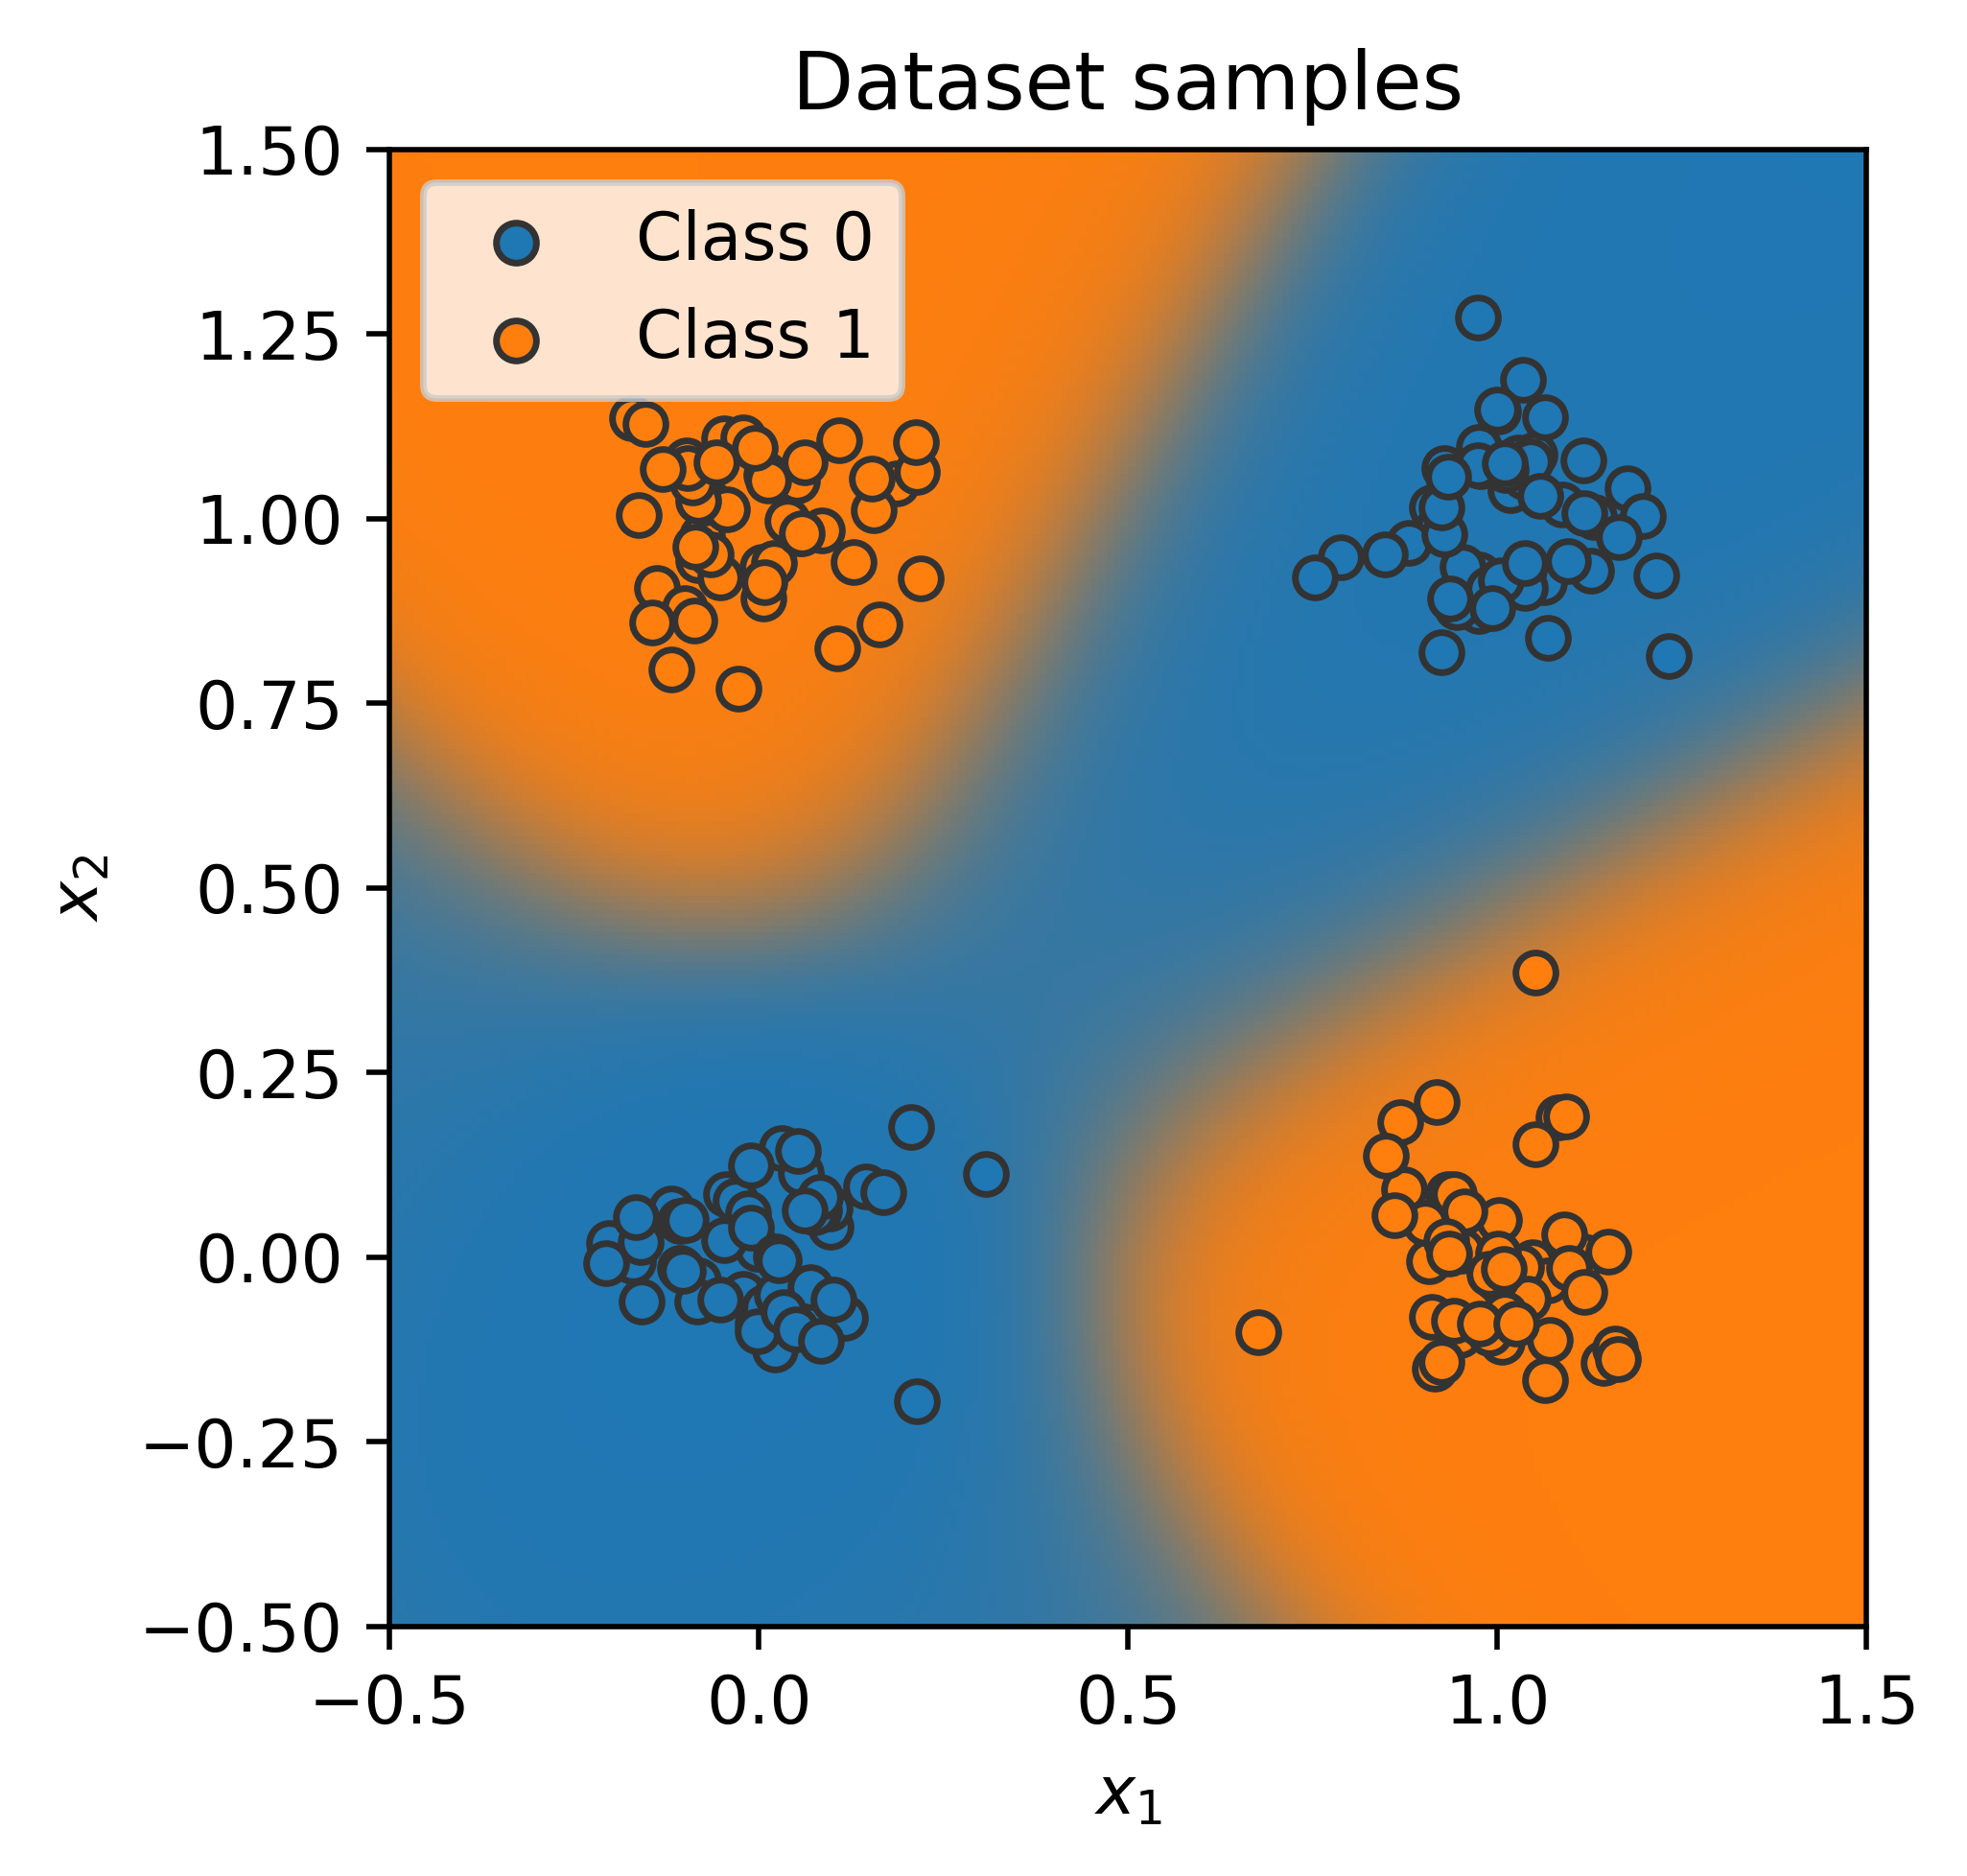

In [50]:
from matplotlib.colors import to_rgba

def visualize_classification(model, data, label):
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    c0 = np.array(to_rgba("C0"))
    c1 = np.array(to_rgba("C1"))
    x1 = jnp.arange(-0.5, 1.5, step=0.01)
    x2 = jnp.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = np.stack([xx1, xx2], axis=-1)
    logits = model(model_inputs)
    preds = nn.sigmoid(logits)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

_ = visualize_classification(trained_model, dataset.x, dataset.y)
plt.show()

### Conclusion

This concludes our tutorial on training a neural network with JAX. While the functional programming perspective of JAX may seem very different to PyTorch at first, it enables a considerable speedup in training, not only for tiny models like here.

## Part D: Operator network architecture

**Task**. Consider a dataset with two kinds of features $y \in \mathbb{R}^{n}$ and $u \in \mathbb{R}^{m}$ and a scalar-valued output variable $z \in \mathbb{R}$.
Create a neural neural network architecture which has the following architecture. It use used for Deep Operator Learning.

<center width="100%"><img src="./onet.png" alt="Feedforward network" width="500px"></center>

Use simple MLP networks for the branch and trunk net, resp. These networks map $y$ and $u$ to temporary outputs in $\mathbb{R}^p$ which are then multiplied and summed to yield the scalar-valued output of the whole network.

You can test your method on behalf of the example considered in **Part B**, although you should increase the size of your data set. It is a good exercise to create a PyTorch dataset from the data and use the data loader and training procedure presented in **Part C**.

In [51]:
# Your code here
# You will probably need some more code cells,
# also create some markdown cells to make your code more readable